<a href="https://colab.research.google.com/github/vedthebest/Pneumonia-Detection/blob/main/pneumonia_detection_EDA_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

''

**Capstone Project - RSNA Pneumonia Detection Challenge
Problem Statement**

In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image. Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image. While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related. In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

## Import Packages

In [15]:
import pandas as pd
from matplotlib.patches import Rectangle
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from glob import glob
from skimage.transform import resize
from skimage import io, measure
import cv2, random

Mount the data drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Exploratory Data Analysis (EDA)**

## Here as a part of EDA, we will:

*   Start with understanding of the data with a brief on train/test labels and respective class info
*   Look at the first five rows of both the csvs (train and test)
*   Identify how are classes and target distributed
*   Check the number of patients with 1, 2, ... bounding boxes
*   Read and extract metadata from dicom files
*   Perform analysis on some of the features from dicom files
*   Check some random images from the training dataset
*   Draw insights from the data at various stages of EDA

## Reading CSVs

Images for the current stage in the stage_2_train_images and stage_2_test_images.

Training data: stage_2_train_labels.csv
stage_2_detailed_class_info.csv containing detailed information about the positive and negative classes in the training set

In [8]:
#load train labels in df
train_labels_df = pd.read_csv("/content/drive/MyDrive/capstone/stage_2_train_labels.csv")

In [9]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


The bounding box information is present for only 9555 records out of 30227.

In [6]:
train_labels_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


### Read the deatiled class info data

In [10]:
detail_df = pd.read_csv("/content/drive/MyDrive/capstone/stage_2_detailed_class_info.csv")

In [15]:
detail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [16]:
detail_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [11]:
detail_df['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

There are 3 classes 

 > 1) Normal

 > 2) Lung Opacity

 > 3) No lung opacity /not normal (which is not related to pneumonia.)







Let's merge the labels and details dataframe

In [12]:
#merge the two df's and drop target
merged_df=pd.concat([train_labels_df,detail_df['class']],axis = 1 )

In [19]:
merged_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [20]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.6+ MB


In [21]:
merged_df['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

The classes seem to be fairly distributed. 

In [22]:
import numpy as np
import matplotlib.pyplot as plot

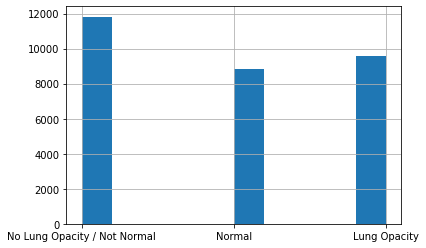

In [23]:
merged_df['class'].hist()

In [24]:
pd.isnull(merged_df).sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64

There are many NAN's for x, y, width and height. lets find the class corresponding to these NAN's



In [13]:
new_df=merged_df[merged_df.isna().any(axis=1)]

In [26]:
new_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [27]:
new_df['class'].value_counts()

No Lung Opacity / Not Normal    11821
Normal                           8851
Name: class, dtype: int64

As seen above the class of data containing Null's is either "Normal" or "No Lung Opacity/Not Normal" and both do not belong to pneumonia class.
However we will use the data for training so that more variety can be fed to the model.

In [28]:
new_df['Target'].value_counts()

0    20672
Name: Target, dtype: int64

This shows that both no lung opacity/not normal and normal have target as "0" indicating there is no pneumonia.

In [14]:
merged_df['y_max'] = merged_df['y'] + merged_df['height']

In [15]:
merged_df['x_max'] = merged_df['x'] + merged_df['width']

In [31]:
merged_df.head()

,patientId,x,y,width,height,Target,class,y_max,x_max
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,NaN,NaN
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,531.0,477.0


In [17]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 14.2 MB/s 


In [18]:
import pydicom as dcm

In [34]:
merged_df['patientId'].nunique()

26684

There are 26684 unique patient ID's in training data set.

The below listing shows the patient ids and number of bounding boxes.

In [19]:
bar_df=merged_df.groupby('patientId').size().value_counts().reset_index()

In [20]:
bar_df.rename(columns = {'index':'No of BB'}, inplace = True)

In [21]:
bar_df.rename(columns = {bar_df.columns[1]:'No of patients'}, inplace = True)

In [38]:
bar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   No of BB        4 non-null      int64
 1   No of patients  4 non-null      int64
dtypes: int64(2)
memory usage: 192.0 bytes


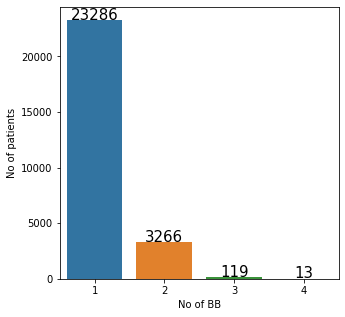

In [39]:
plot.figure(figsize=(5, 5))
plots = sns.barplot(x="No of BB", y="No of patients", data=bar_df)
# Iterrating over the bars one-by-one
for bar in plots.patches:
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 5),
                   textcoords='offset points')

start processing of dcm images.

In [22]:
base_path='/content/drive/MyDrive/capstone/stage_2_train_images'

In [2]:
import os
len(os.listdir(base_path))

FileNotFoundError: ignored

There are 26684 files present in training folder which matches with unique patient records in df.

In [23]:
#read and print dcm metadata
image_path = base_path+'/'+merged_df['patientId'].iloc[0]+'.dcm'
ds = dcm.dcmread(image_path)
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
image_path = base_path+'/'+merged_df['patientId'].iloc[5]+'.dcm'
ds = dcm.dcmread(image_path)
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

dcm file has lot of metadata which can be added to merged df and used for further EDA.

In [ ]:
ds.PixelSpacing[0]

'0.139'

In [25]:
#loop through all the training images and extract their key metadata and make new columns in merged_df.
for idx,pid in enumerate(merged_df['patientId']):
  #print(pid)
  path=base_path+'/'+pid+'.dcm'
  print(path)
  ds = dcm.dcmread(path)
  print(ds)
  #insert metadata into merged_df
  merged_df.loc[idx,'Modality']=ds.Modality
  merged_df.loc[idx,'ConversionType']=ds.ConversionType
  merged_df.loc[idx,'PatientSex']=ds.PatientSex
  merged_df.loc[idx,'PatientAge']=ds.PatientAge
  merged_df.loc[idx,'Body Part Examined']=ds.BodyPartExamined
  merged_df.loc[idx,'ViewPosition']=ds.ViewPosition
  merged_df.loc[idx,'Rows']=ds.Rows
  merged_df.loc[idx,'Columns']=ds.Columns
  merged_df.loc[idx,'PixelSpacing']=ds.PixelSpacing[0]

Streaming output truncated to the last 5000 lines.
(0028, 0102) High Bit                            US: 7
(0028, 0103) Pixel Representation                US: 0
(0028, 2110) Lossy Image Compression             CS: '01'
(0028, 2114) Lossy Image Compression Method      CS: 'ISO_10918_1'
(7fe0, 0010) Pixel Data                          OB: Array of 117640 elements
/content/drive/MyDrive/capstone/stage_2_train_images/3036ca10-8d42-4749-81e2-8ed235a6a567.dcm
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.9424.1517874342.988537
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Impl

In [ ]:
merged_df.head()

,patientId,x,y,width,height,Target,class,y_max,x_max,Modality,ConversionType,PatientSex,PatientAge,Body Part Examined,ViewPosition,Rows,Columns,PixelSpacing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,CR,WSD,F,51,CHEST,PA,1024.0,1024.0,0.143000
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,CR,WSD,F,48,CHEST,PA,1024.0,1024.0,0.194311
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,CR,WSD,M,19,CHEST,AP,1024.0,1024.0,0.168000
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,NaN,NaN,CR,WSD,M,28,CHEST,PA,1024.0,1024.0,0.143000
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,531.0,477.0,CR,WSD,F,32,CHEST,AP,1024.0,1024.0,0.139000


In [ ]:
#convert patient age to number
merged_df['PatientAge']=pd.to_numeric(merged_df['PatientAge'])

In [ ]:
# Saving the training_data for further use:
merged_df.to_pickle('merged_df.pkl')

perform EDA on the merged data.

In [ ]:
merged_df = pd.read_pickle('merged_df.pkl')

In [ ]:
merged_df['Body Part Examined'].value_counts()

CHEST    30227
Name: Body Part Examined, dtype: int64

All the data is collected from chest region.

In [ ]:
merged_df['ConversionType'].value_counts()

WSD    30227
Name: ConversionType, dtype: int64

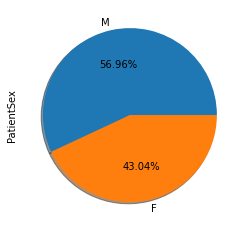

In [ ]:
merged_df['PatientSex'].value_counts().plot(kind='pie',autopct='%1.2f%%',shadow='True')

There are 56.96% male patients and roughly 43% female patients.

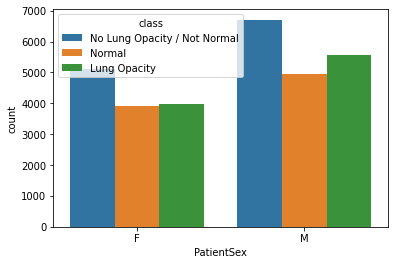

In [ ]:
sns.countplot(x = merged_df['PatientSex'], data = merged_df,  hue = 'class')

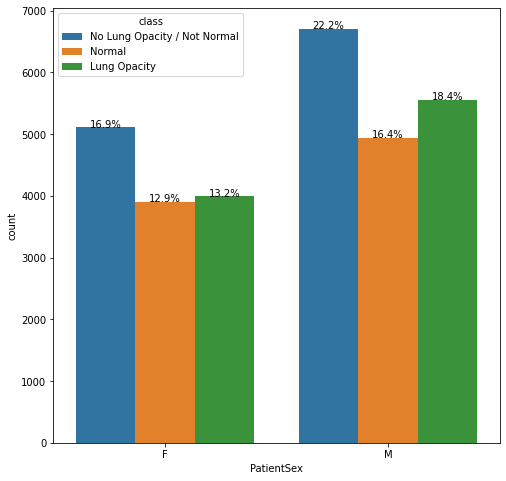

In [ ]:
plot.figure(figsize=(8, 8))
plots = sns.countplot(x="PatientSex", hue="class", data=merged_df)
total=30227
# Iterrating over the bars one-by-one
for p in plots.patches:
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    plots.annotate(percentage, (x, y),ha='center')
plot.show()
    

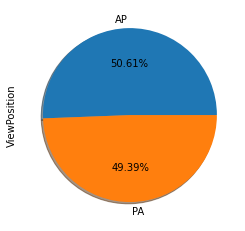

In [ ]:
merged_df['ViewPosition'].value_counts().plot(kind='pie',autopct='%1.2f%%',shadow='True')

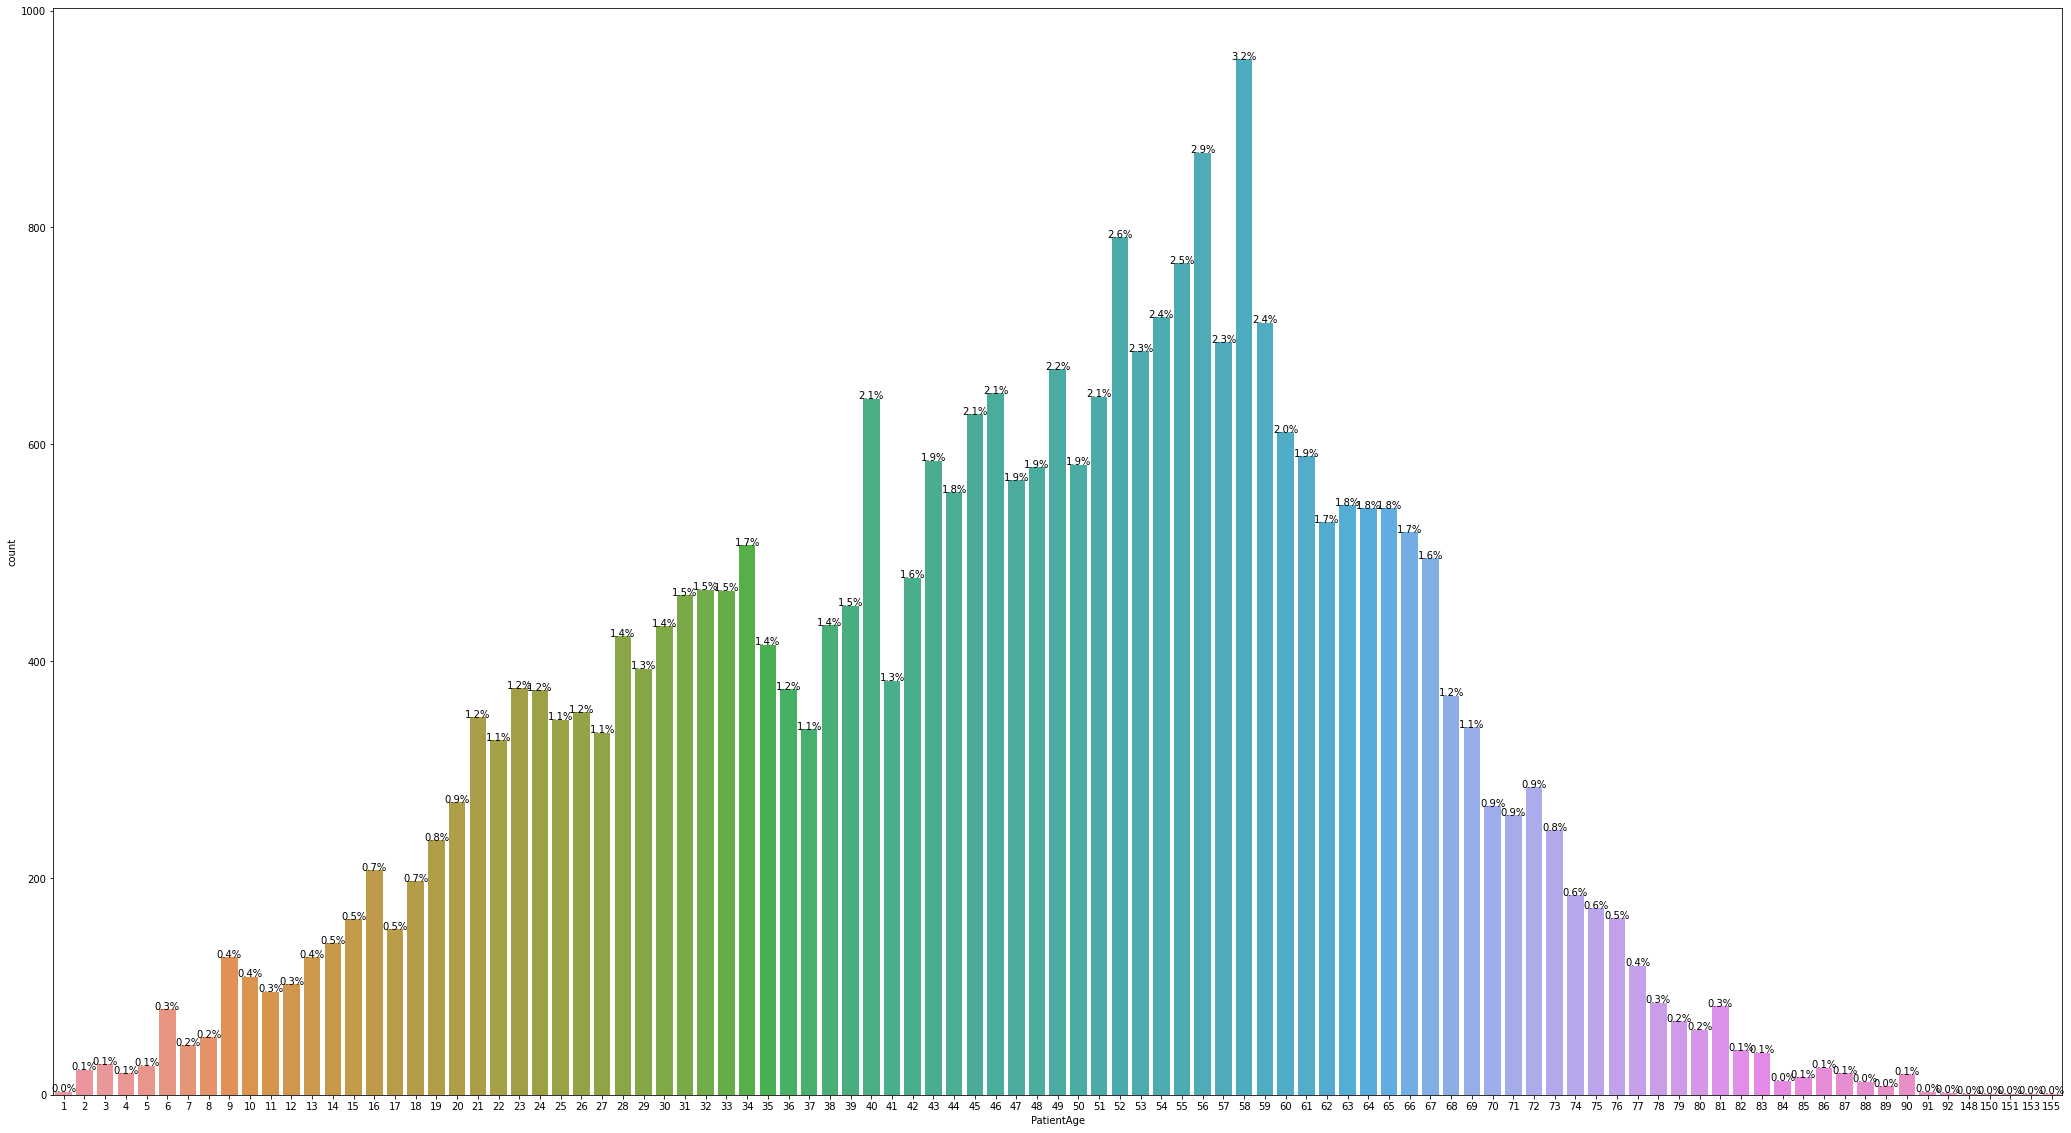

In [ ]:
#merged_df['PatientAge'].value_counts().plot(kind='countplot',figsize=(24,8))
plot.figure(figsize=(36,20))
plots=sns.countplot(x='PatientAge',data=merged_df.sort_values('PatientAge'))
total=30227
# Iterrating over the bars one-by-one
for p in plots.patches:
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    plots.annotate(percentage, (x, y),ha='center')
plot.show()

The age numbers exist beyond 100 indicating the data may have been recorded incorrectly.

In [ ]:
merged_df[merged_df['PatientAge']>=100]['patientId']

3921     3b8b8777-a1f6-4384-872a-28b95f59bf0d
11032    73aeea88-fc48-4030-8564-0a9d7fdecac4
17213    a4e8e96d-93a6-4251-b617-91382e610fab
26488    ec3697bd-184e-44ba-9688-ff8d5fbf9bbc
27746    f632328d-5819-4b29-b54f-adf4934bbee6
Name: patientId, dtype: object

There are 5 records with age beyond 100.

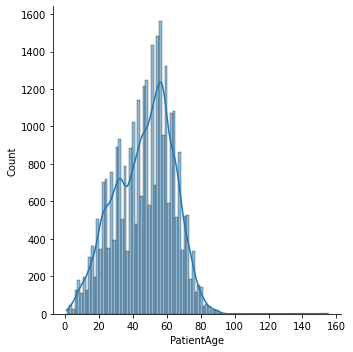

In [ ]:
sns.displot(merged_df['PatientAge'],kde='true')

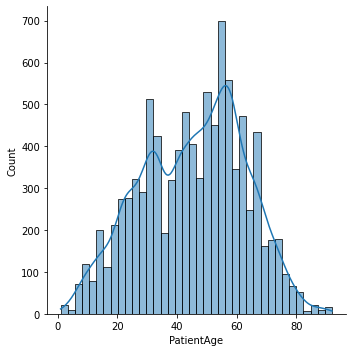

In [ ]:
tmp_df=merged_df[merged_df['Target']==1]
#tmp_df.head()
sns.displot(tmp_df['PatientAge'],kde='true')

lets group the ages and explore target and class distribution.

In [ ]:
patient_age_arr = np.linspace(0, 160, 17)

In [ ]:
merged_df['PatientAgeGroup'] = pd.cut(merged_df['PatientAge'], patient_age_arr)
merged_df['PatientAgeGroup'].value_counts()

(50.0, 60.0]      7446
(40.0, 50.0]      5671
(60.0, 70.0]      4730
(30.0, 40.0]      4551
(20.0, 30.0]      3704
(10.0, 20.0]      1688
(70.0, 80.0]      1637
(0.0, 10.0]        515
(80.0, 90.0]       275
(90.0, 100.0]        5
(150.0, 160.0]       3
(140.0, 150.0]       2
(100.0, 110.0]       0
(110.0, 120.0]       0
(120.0, 130.0]       0
(130.0, 140.0]       0
Name: PatientAgeGroup, dtype: int64

Most patients are in age brackets [50-60],[40-50]. Those is ages below 10 and above 80 are not impacted.

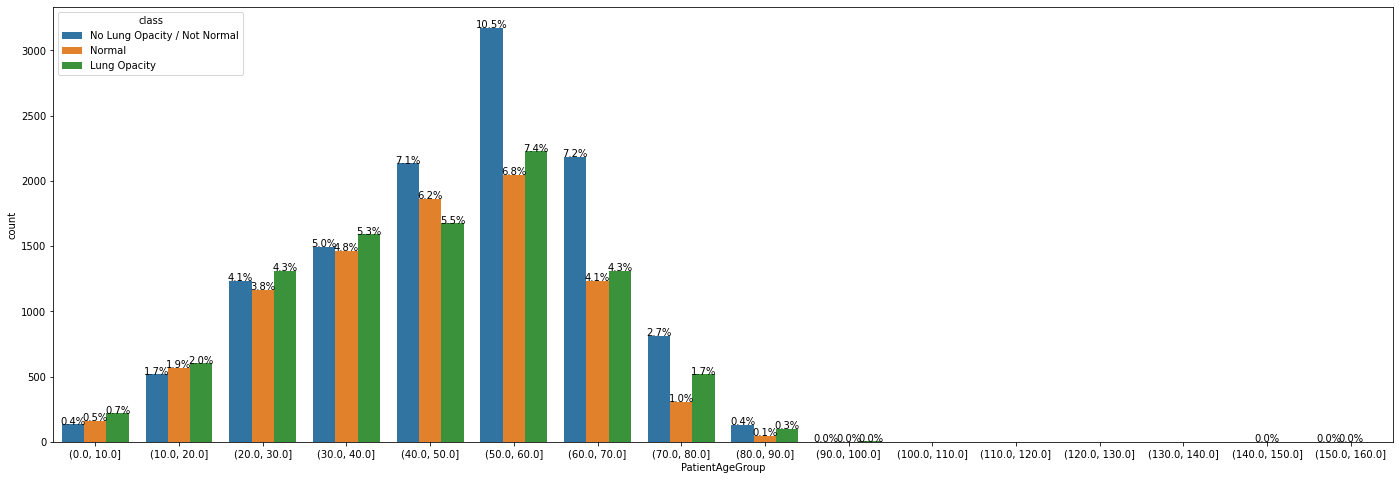

In [ ]:
plot.figure(figsize=(24, 8))
plots = sns.countplot(x="PatientAgeGroup", hue="class", data=merged_df)
total=30227
# Iterrating over the bars one-by-one
for p in plots.patches:
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    plots.annotate(percentage, (x, y),ha='center')
plot.show()

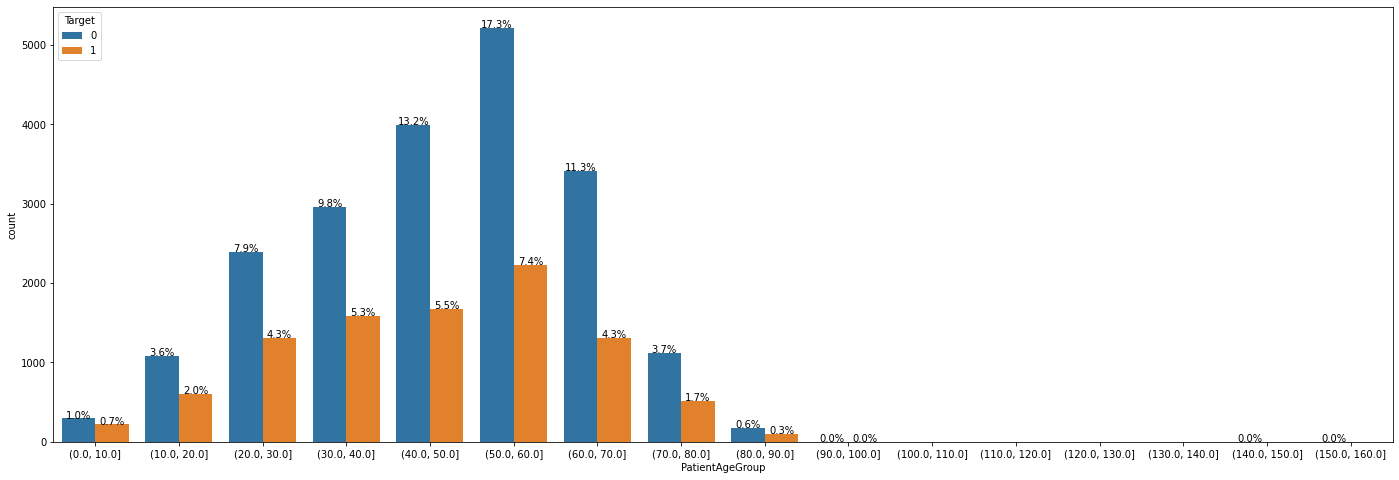

In [ ]:
plot.figure(figsize=(24, 8))
plots = sns.countplot(x="PatientAgeGroup", hue="Target", data=merged_df)
total=30227
# Iterrating over the bars one-by-one
for p in plots.patches:
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    plots.annotate(percentage, (x, y),ha='center')
plot.show()

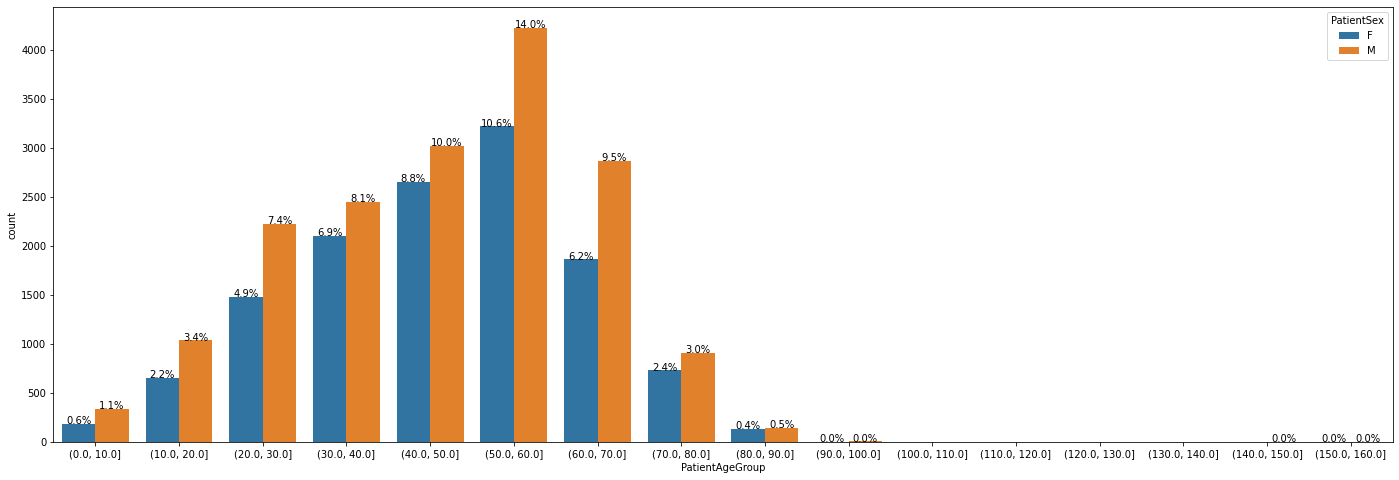

In [ ]:
plot.figure(figsize=(24, 8))
plots = sns.countplot(x="PatientAgeGroup", hue="PatientSex", data=merged_df)
total=30227
# Iterrating over the bars one-by-one
for p in plots.patches:
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    plots.annotate(percentage, (x, y),ha='center')
plot.show()

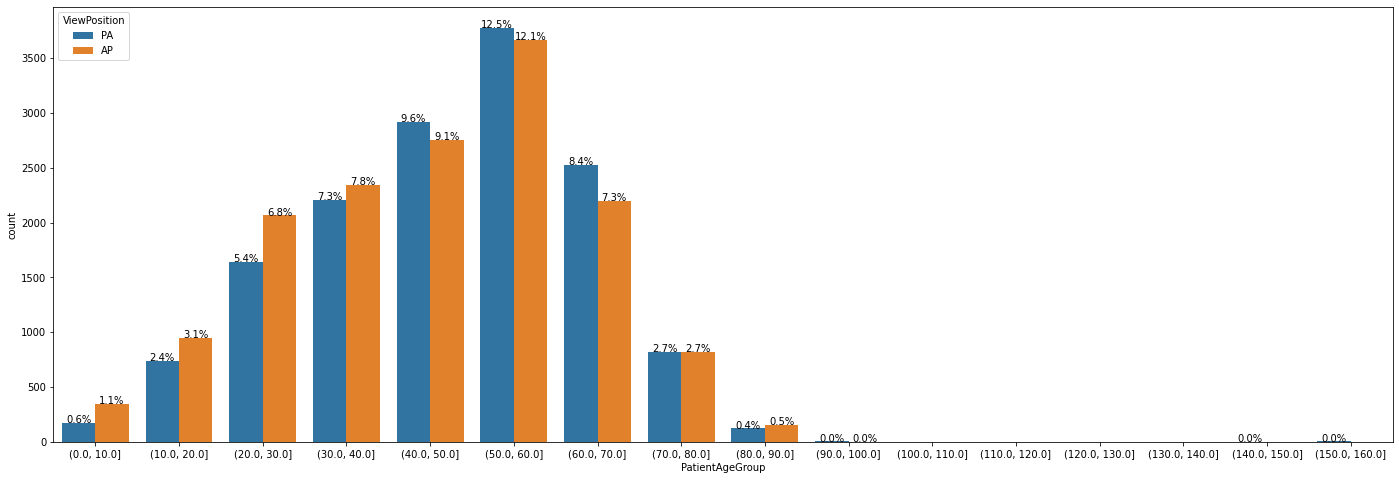

In [ ]:
plot.figure(figsize=(24, 8))
plots = sns.countplot(x="PatientAgeGroup", hue="ViewPosition", data=merged_df)
total=30227
# Iterrating over the bars one-by-one
for p in plots.patches:
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    plots.annotate(percentage, (x, y),ha='center')
plot.show()

In [4]:
# Saving the training_data for further use:
merged_df.to_pickle('/content/drive/MyDrive/Colab/capstoneCV1/pklfiles/merged_df.pkl')

NameError: ignored

Lets explore bounding boxes.

In [12]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 5.0 MB/s 


In [20]:

import pydicom as dcm
from google.colab.patches import cv2_imshow

In [7]:
#load the saved pickle file.
load_df= pd.read_pickle('/content/drive/MyDrive/capstone//merged_df.pkl')

In [8]:
load_df['x']=load_df['x'].fillna(0)
load_df['y']=load_df['y'].fillna(0)
load_df['y_max']=load_df['y_max'].fillna(0)
load_df['x_max']=load_df['x_max'].fillna(0)

In [9]:
t_df=load_df[load_df['Target']==1]

In [21]:
base_path='/content/drive/MyDrive/capstone/stage_2_train_images'
def show_image_bb(df,index):
  image_path = base_path+'/'+df.iloc[index]['patientId']+'.dcm'
  ds = dcm.dcmread(image_path)
  img=ds.pixel_array # store pixel data
     
  # Blue color in BGR
  color = (255, 0, 0)
  thickness = 4
  start_point=(int(df.iloc[index]['x']),int(df.iloc[index]['y']))
  end_point = (int(df.iloc[index]['x_max']),int(df.iloc[index]['y_max']))
  img = cv2.rectangle(img, start_point, end_point, color, thickness)
  img=cv2.resize(img, (256, 256))
  # add patient profile
  print("Age:",df.iloc[index]['PatientAge'],"ID:",df.iloc[index]['patientId'])
  print("Sex:",df.iloc[index]['PatientSex'],"View:",df.iloc[index]['ViewPosition'],"Class:",df.iloc[index]['class'])
  cv2_imshow(img)


Age: 32 ID: 00436515-870c-4b36-a041-de91049b9ab4
Sex: F View: AP Class: Lung Opacity


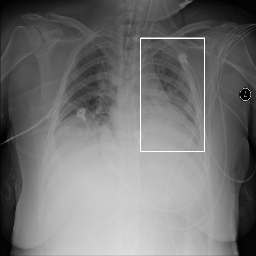

In [22]:
show_image_bb(t_df,1)

Age: 34 ID: 02099738-7465-4786-b71c-de8cdac477c3
Sex: F View: AP Class: Lung Opacity


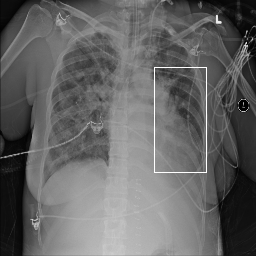

In [23]:
show_image_bb(t_df,45)

Age: 66 ID: 31102758-a5ba-44c9-b480-b744bcfcb861
Sex: F View: AP Class: Lung Opacity


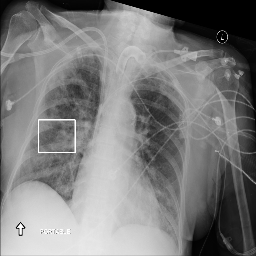

In [24]:
show_image_bb(t_df,1000)

lets display images with multiple bounding boxes

In [25]:
dup_df=t_df[t_df.duplicated('patientId',keep=False)]

In [26]:
dup_df.head()

,patientId,x,y,width,height,Target,class,y_max,x_max,Modality,ConversionType,PatientSex,PatientAge,Body Part Examined,ViewPosition,Rows,Columns,PixelSpacing,PatientAgeGroup
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,531.0,477.0,CR,WSD,F,32,CHEST,AP,1024.0,1024.0,0.139,"(30.0, 40.0]"
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,605.0,818.0,CR,WSD,F,32,CHEST,AP,1024.0,1024.0,0.139,"(30.0, 40.0]"
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,681.0,483.0,CR,WSD,M,75,CHEST,PA,1024.0,1024.0,0.143,"(70.0, 80.0]"
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,712.0,857.0,CR,WSD,M,75,CHEST,PA,1024.0,1024.0,0.143,"(70.0, 80.0]"
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,Lung Opacity,457.0,382.0,CR,WSD,F,6,CHEST,AP,1024.0,1024.0,0.168,"(0.0, 10.0]"


In [27]:
dup_df.shape

(6941, 19)

There are 6941 duplicate records.

In [28]:
dup_pid_arr=dup_df['patientId'].unique()

In [29]:
len(dup_pid_arr)

3398

In [30]:
#choose any two patient Id's
print(dup_pid_arr[0])
print(dup_pid_arr[5])

00436515-870c-4b36-a041-de91049b9ab4
010ccb9f-6d46-4380-af11-84f87397a1b8


In [31]:
def show_duplicates_bb(df,index,ptid):

  #find number of BB's and their {x,y,x_max,y_max}
  if(index>=0):
    #find patient ID of index
    pid= df.iloc[index]['patientId']
  else:
    pid=ptid

  #find count of records
  pid_count=df[df['patientId']==pid].value_counts().sum()
  print(pid,pid_count)
  tdf=df[df['patientId']==pid]
  image_path = base_path+'/'+pid+'.dcm'
  ds = dcm.dcmread(image_path)
  img=ds.pixel_array # store pixel data
  for idx in range(pid_count):
    x=tdf.iloc[idx]['x']
    y=tdf.iloc[idx]['y']
    x_max=tdf.iloc[idx]['x_max']
    y_max=tdf.iloc[idx]['y_max']
    print(pid,x,y,x_max,y_max)
     
    # Blue color in BGR
    color = (255, 0,0)

    if(idx > 0):
      color = (0, 255,128+(idx*25))
    
    thickness = 4
    start_point=(int(x),int(y))
    end_point = (int(x_max),int(y_max))
    img = cv2.rectangle(img, start_point, end_point, color, thickness)
  
    
  img=cv2.resize(img, (256, 256))
  # add patient profile
  print("Age:",df.iloc[index]['PatientAge'],"ID:",df.iloc[index]['patientId'])
  print("Sex:",df.iloc[index]['PatientSex'],"View:",df.iloc[index]['ViewPosition'],"Class:",df.iloc[index]['class'])
  cv2_imshow(img)

00436515-870c-4b36-a041-de91049b9ab4 2
00436515-870c-4b36-a041-de91049b9ab4 264.0 152.0 477.0 531.0
00436515-870c-4b36-a041-de91049b9ab4 562.0 152.0 818.0 605.0
Age: 32 ID: 00436515-870c-4b36-a041-de91049b9ab4
Sex: F View: AP Class: Lung Opacity


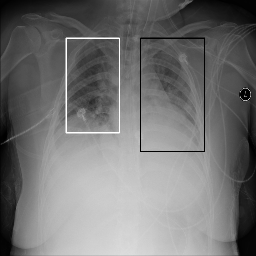

In [32]:
show_duplicates_bb(dup_df,0,0)

In [33]:
pid_max=dup_df['patientId'].value_counts().idxmax()
pid_max

'ee820aa5-4804-4984-97b3-f0a71d69702f'

In [34]:
pid_max_idx=dup_df[dup_df['patientId']==pid_max]
pid_max_idx

,patientId,x,y,width,height,Target,class,y_max,x_max,Modality,ConversionType,PatientSex,PatientAge,Body Part Examined,ViewPosition,Rows,Columns,PixelSpacing,PatientAgeGroup
26782,ee820aa5-4804-4984-97b3-f0a71d69702f,605.0,228.0,154.0,223.0,1,Lung Opacity,451.0,759.0,CR,WSD,M,24,CHEST,AP,1024.0,1024.0,0.168,"(20.0, 30.0]"
26783,ee820aa5-4804-4984-97b3-f0a71d69702f,634.0,569.0,193.0,175.0,1,Lung Opacity,744.0,827.0,CR,WSD,M,24,CHEST,AP,1024.0,1024.0,0.168,"(20.0, 30.0]"
26784,ee820aa5-4804-4984-97b3-f0a71d69702f,211.0,238.0,167.0,235.0,1,Lung Opacity,473.0,378.0,CR,WSD,M,24,CHEST,AP,1024.0,1024.0,0.168,"(20.0, 30.0]"
26785,ee820aa5-4804-4984-97b3-f0a71d69702f,168.0,611.0,158.0,117.0,1,Lung Opacity,728.0,326.0,CR,WSD,M,24,CHEST,AP,1024.0,1024.0,0.168,"(20.0, 30.0]"


ee820aa5-4804-4984-97b3-f0a71d69702f 4
ee820aa5-4804-4984-97b3-f0a71d69702f 605.0 228.0 759.0 451.0
ee820aa5-4804-4984-97b3-f0a71d69702f 634.0 569.0 827.0 744.0
ee820aa5-4804-4984-97b3-f0a71d69702f 211.0 238.0 378.0 473.0
ee820aa5-4804-4984-97b3-f0a71d69702f 168.0 611.0 326.0 728.0
Age: 72 ID: c1f7889a-9ea9-4acb-b64c-b737c929599a
Sex: F View: AP Class: Lung Opacity


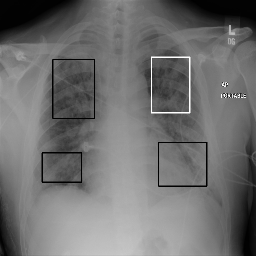

In [ ]:
show_duplicates_bb(dup_df,-1,pid_max)